In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phaseportrait as pp
from scipy.constants import convert_temperature as conv_temp

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_T_top
from controllers import LQRControllerDisc
from controllers import LQRControllerCont
from controllers import MPCController
from classes import LEDparams, Model
from system import Simulation

In [ ]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 8 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K

# Tracking
tracking_tol = 0.5 # °C or K
stop_cond_DT = 3 # K
max_iter = 8

# Initialize
current_DT = -20 # °C or K

num_P_rad = 3
P_rad_vec = np.linspace(0, 1, num_P_rad)

## Start simulation loop
columns = ['P_rad', 'DT', 'Tracking', 'T_amb', 'T_cell_ref']
lw_bound_df = pd.DataFrame(columns=columns)

sim_results_list = []
leg_titles = []
sim_num = 0
for P_rad_iter in range(num_P_rad):
    DT_step = 20 # °C or K
    DT_iter = 0
    prev_false_DT = None
    prev_true_DT = None

    while True:
        DT_iter = DT_iter + 1

        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_cell_ref - current_DT

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])
        
        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        # LQR
        q1 = 0
        q2 = 20 #/ (T_amb0**2)
        q3 = 0
        Q = np.array([[q1, 0, 0],
                      [0, q2, 0],
                      [0, 0, q3]])
        r1 = 10 / model.I_HP_max**2
        r2 = 4
        R = np.array([[r1, 0 ],
                      [0,  r2]])

        Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
        lqr_controller_disc    = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)

        # Simulation
        sim = Simulation(model=model, controller=lqr_controller_disc, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=False, initial_time_span=10)
        
        results['id_sim']    = sim_num
        results['P_rad'] = P_rad_iter
        results['DT'] = current_DT
        sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.1f}W"
        
        # P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        # title_P_LED = r"$P_\mathrm{LED} =$" + f"{P_LED:.1f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_\mathrm{bt}^\mathrm{tot} =$" + f"{E_BT_tot:.2f}J"

        fig_title = title_P_rad + "     " + title_E_BT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        leg_titles.append(leg_title)

        # Save plot
        filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
        filename = filename.replace(".", "_")

        # Plot sim results
        sim.plot_time_results(fig_title, save_plot=False, filename=filename)
        # sim.plot_current_temperature(fig_title, save_plot=False, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

        ### Grid search
        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol
        print(f"Current DT: {current_DT}, Current is tracking: {current_is_tracking}")

        # Save data
        lw_bound_df = pd.concat([lw_bound_df, pd.DataFrame([[P_rad, current_DT, current_is_tracking, T_amb, T_cell_ref]], columns=columns)], ignore_index=True)

        # First call until both not None: found a tracking and not tracking solution
        if prev_false_DT is None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up

        # If previous is tracking
        elif prev_false_DT is None and prev_true_DT is not None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2

        # If previous is not tracking
        elif prev_false_DT is not None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up
        
        # If both not None
        else:
            if current_is_tracking:
                prev_true_DT = current_DT
            else:
                prev_false_DT = current_DT

            # step size halving
            DT_step = DT_step / 2
            current_DT = (prev_true_DT + prev_false_DT) / 2

        # Stop condition
        if abs(DT_step) <= stop_cond_DT or DT_iter >= max_iter:
            print("Stop condition reached.")
            break

# All results
all_results_df = pd.concat(sim_results_list).set_index(['id_sim', 'P_rad', 'DT', 'time'])

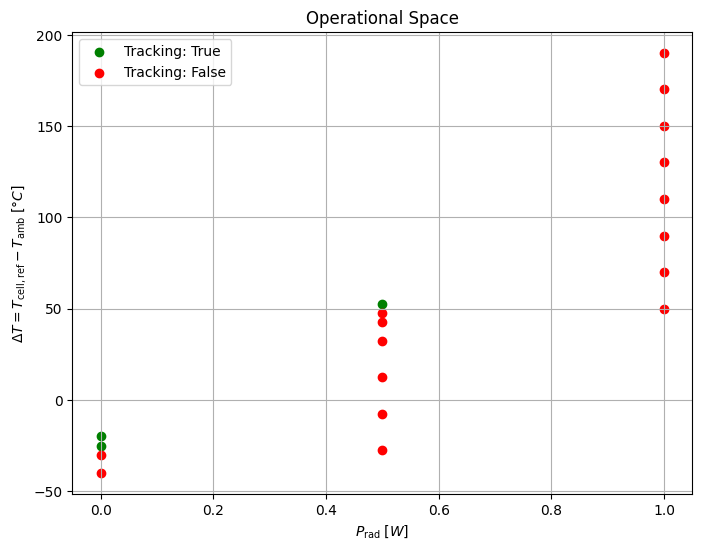

In [98]:
# Plotting
# Separate the data based on the Tracking column
tracking_true = lw_bound_df[lw_bound_df['Tracking'] == True]
tracking_false = lw_bound_df[lw_bound_df['Tracking'] == False]

# Plotting
plt.figure(figsize=(8, 6))

# Plot points where Tracking is True in green
plt.scatter(tracking_true['P_rad'], tracking_true['DT'], color='green', label='Tracking: True')

# Plot points where Tracking is False in red
plt.scatter(tracking_false['P_rad'], tracking_false['DT'], color='red', label='Tracking: False')


plt.xlabel(r'$P_\mathrm{rad} \; [W]$')
plt.ylabel(r'$\Delta T = T_\mathrm{cell,ref} - T_\mathrm{amb} \; [°C]$')
plt.title('Operational Space')
plt.grid()
plt.legend()
plt.show()